<a href="https://colab.research.google.com/github/pluzharovakp/ds_projects/blob/master/Kristina_Pluzharova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Plan**

1. Data Preprocessing
Drop NaN values and duplicates. Convert data to the faster readable format
2. Preprocess given keywords and use them to select reviews related to localization
3. Determine Language the reviews were written on and put it in the separate column. Translate all reviews to English
4. Determine sentiments of the reviews with VADER
5. EDA 
6. Conclusion + Dashboard



# Imports and preprocessing

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install langdetect nltk  deep_translator

     |████████████████████████████████| 983kB 15.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993223 sha256=18162673bed923d6f16678c0bac805f193005aa314d5146f7328b2e1eff28e27
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
import nltk
nltk.download('wordnet')
from deep_translator import GoogleTranslator
import pandas as pd
import numpy as np
from textblob import TextBlob
import langdetect
from nltk.stem.snowball import SnowballStemmer
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# reviews1 =  pd.read_excel('/content/drive/My Drive/data/REVIEWS_1.xlsx')

In [ ]:
# reviews2 =  pd.read_excel('/content/drive/My Drive/data/REVIEWS_2.xlsx')

In [ ]:
# df = pd.concat([reviews1, reviews2])

In [ ]:
# df.info()

In [ ]:
# df.to_csv('/content/drive/My Drive/data/df.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/df.csv', index_col=0)

In [ ]:
df.columns = ['id', 'score', 'text']

In [ ]:
df.shape

(1869775, 3)

In [ ]:
df.head()

,id,score,text
0,title777,4,"Velmi návyková hra, skvěle zpracovaná. Jen ško..."
1,title777,4,"Hra hezká, vadí mi, že třeba přes noc se nepln..."
2,title777,5,Cool
3,title777,5,Suprová hra.
4,title777,5,"⚽️🏀🏈⚾️🥎去浏览器打开📲87ṚмＢ,C☻м📲华人最大娱乐站，开户免费送现金100块‼️-..."


In [ ]:
df = df.dropna()

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

# Select localization reviews 

In [ ]:
keywords = pd.read_excel('/content/drive/My Drive/data/Keywords.xlsx')

In [ ]:
keywords

,Language combination,"""Translation""","""Language""","""Localization""","""English""",Language,Unnamed: 6,ISO 639-1,ISO 3166-1-alpha-2,Unnamed: 9
0,English - French,Traduction,la langue,localisation,anglais,Français,NaN,FR,FR,NaN
1,English - German,Übersetzung,Sprache,Lokalisierung,Englisch,Deutsch,NaN,DE,DE,NaN
2,English - Italian,traduzione,lingua,localizzazione,inglese,Italiano,NaN,IT,IT,NaN
3,English - Spanish,traducción,idioma,localización,inglés,español,NaN,ES,ES,NaN
4,English - Chinese Simplified,翻译,语言,本土化,英语,中国,NaN,ZH,CN,NaN
5,English - Chinese Traditional,翻譯,語言,本土化,英語,中國,NaN,ZH,CN,NaN
6,English - Japanese,翻訳,言語,局地化,英語,日本,NaN,JA,JP,NaN
7,English - Korean,번역,언어,지방화,영어,한국,NaN,KO,KR,NaN
8,English - Portuguese (BRZ),tradução,língua,localização,inglês,Portugues,NaN,PT,BR,NaN
9,English - Portuguese (EUR),tradução,língua,localização,inglês,Portugues,NaN,PT,PT,NaN


In [ ]:
keywords = keywords.drop(29, axis=0)

In [ ]:
keywords['Language combination'] = keywords['Language combination'].str.replace('English - ', '')

In [ ]:
keywords_list = keywords['"Translation"'].tolist() + keywords['"Language"'].tolist() + keywords['"Localization"'].tolist() + keywords['"English"'].tolist() + keywords['Language'].tolist() + keywords['Language combination'].tolist()

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
stemmer_rus = SnowballStemmer('russian')
keywords_stem = [stemmer.stem(word) for word in keywords_list]

In [ ]:
keywords_stem = keywords_stem + ['翻译', '语言', '中文',  '中国',  '汉语', '本土化', '英语', '版本',
        '区域', '跨地区', '地区', '华语', '汉化', '英文', '国家', '国服', 'VPN', 'русс', 'англ']

In [ ]:
keywords_stem = [keywords_stem[i].replace(' ', '') for i in range(len(keywords_stem))]

In [ ]:
keywords_string = '|'.join(keywords_stem)

In [ ]:
df['is_about_localization'] = df['text'].str.lower().str.contains(keywords_string.lower())

In [ ]:
df.head()

,id,score,text,is_about_localization
0,title777,4,"Velmi návyková hra, skvěle zpracovaná. Jen ško...",False
1,title777,4,"Hra hezká, vadí mi, že třeba přes noc se nepln...",False
2,title777,5,Cool,False
3,title777,5,Suprová hra.,False
4,title777,5,"⚽️🏀🏈⚾️🥎去浏览器打开📲87ṚмＢ,C☻м📲华人最大娱乐站，开户免费送现金100块‼️-...",False


In [ ]:
df_loc = df[df['is_about_localization']==True]

In [ ]:
df_loc.shape

(36031, 4)

In [ ]:
df_loc

,id,score,text,is_about_localization
8,title777,1,没有华语版本,True
11,title777,5,没有中文字.很难玩-很好玩的游戏.只可惜语言不明,True
176,title777,5,Excellent en français et connexion Facebook sa...,True
967,title777,5,재밌어요. 영어까막눈이라 한국어 패치 됐음 좋겠어요.,True
968,title777,5,연료.. 너무안주고ㅜ 한국어로좀 번역좀해주시지. .정보도없고ㅜㅜ 잼있긴 잼있음 ㅋㅋ,True
...,...,...,...,...
1560168,title642,5,HARİKA YOL YAPMA VE ARABALAR HARİKA ONDAN 5 YI...,True
1560176,title642,5,Oyun fanadil,True
1560184,title642,3,güzel gibi yol yapıp arabaları geçirmeye çalış...,True
1560757,title642,2,I really like this game but they should update...,True


# Detect language and translate the reviews


## Determine language

In [ ]:
def clear_text(text):
    new_text = re.sub(r"[^a-zA-Z']", " ", text) 
    new_text = new_text.split()
    new_text = " ".join(new_text)
    return new_text.lower()

In [ ]:
# df_loc['text_norm'] = df_loc['text'].apply(clear_text)

In [ ]:
def determine_language(text):
    try:
      return langdetect.detect(text)
    except:
      return None

In [ ]:
# df_loc['language'] = [detect(row['text']) for index, row in df_loc.iterrows()]
df_loc['language'] = df_loc['text'].apply(determine_language)

In [ ]:
df_loc['language'].unique()

array(['zh-cn', 'fr', 'ko', 'ja', 'pt', 'pl', 'ru', 'en', 'tr', 'de',
       'vi', 'it', 'no', 'th', 'es', 'hu', 'zh-tw', 'tl', 'af', 'et',
       'cs', 'cy', 'hi', 'sl', 'so', 'sk', 'fi', 'ar', 'id', 'ca', 'nl',
       'el', 'he', 'da', 'bg', 'mk', 'uk', 'sq', 'hr', 'sv', 'lv', 'lt',
       'mr', 'ro', None, 'sw'], dtype=object)

In [ ]:
df_loc[df_loc['language'].isnull()]

,id,score,text,is_about_localization,language
403379,title249,1,RUSSIAN tanks/planes are the way to go...........,True,None


In [ ]:
df_loc['language'] = df_loc['language'].fillna('en')

In [ ]:
df_loc.groupby('language')['language'].count().sort_values()

language
mr          1
lt          3
hi          3
lv          3
mk          3
sw         10
uk         11
hr         11
hu         12
sk         15
sq         15
cy         17
ro         17
bg         21
he         22
fi         29
da         31
sv         35
sl         38
ca         40
et         41
el         46
no         50
so         52
tl         83
af         99
vi        108
cs        120
zh-tw     167
nl        316
pl        772
ar        796
ja        804
es        884
it       1367
de       1405
fr       1498
id       1583
ko       1611
th       1731
ru       2579
zh-cn    3133
pt       3754
tr       4509
en       8186
Name: language, dtype: int64

In [ ]:
df_loc['language'] = df_loc['language'].str.replace('zh-tw', 'zh')
df_loc['language'] = df_loc['language'].str.replace('zh-cn', 'zh') 

In [ ]:
table_lang_and_codes = keywords[['Language combination', 'ISO 639-1']]

In [ ]:
table_lang_and_codes['ISO 639-1'] = table_lang_and_codes['ISO 639-1'].str.lower()

In [ ]:
table_lang_and_codes.columns = ['language_full', 'language']

In [ ]:
table_lang_and_codes['language'] = table_lang_and_codes['language'].drop_duplicates()

In [ ]:
table_lang_and_codes = table_lang_and_codes.dropna()

In [ ]:
table_lang_and_codes['language_full'] = table_lang_and_codes['language_full'].str.replace('Chinese Simplified', 'Chinese')

In [ ]:
table_lang_and_codes['language_full'] = table_lang_and_codes['language_full'].where(table_lang_and_codes['language_full'] != 'Portuguese (BRZ)', 'Portuguese')

In [ ]:
table_lang_and_codes

,language_full,language
0,French,fr
1,German,de
2,Italian,it
3,Spanish,es
4,Chinese,zh
6,Japanese,ja
7,Korean,ko
8,Portuguese,pt
10,Polish,pl
11,Turkish,tr


In [ ]:
df_loc_new = df_loc.merge(table_lang_and_codes, on='language', how='left')

In [ ]:
df_loc_new

,id,score,text,is_about_localization,language,language_full
0,title777,1,没有华语版本,True,zh,Chinese
1,title777,5,没有中文字.很难玩-很好玩的游戏.只可惜语言不明,True,zh,Chinese
2,title777,5,Excellent en français et connexion Facebook sa...,True,fr,French
3,title777,5,재밌어요. 영어까막눈이라 한국어 패치 됐음 좋겠어요.,True,ko,Korean
4,title777,5,연료.. 너무안주고ㅜ 한국어로좀 번역좀해주시지. .정보도없고ㅜㅜ 잼있긴 잼있음 ㅋㅋ,True,ko,Korean
...,...,...,...,...,...,...
36026,title642,5,HARİKA YOL YAPMA VE ARABALAR HARİKA ONDAN 5 YI...,True,en,English
36027,title642,5,Oyun fanadil,True,tr,Turkish
36028,title642,3,güzel gibi yol yapıp arabaları geçirmeye çalış...,True,tr,Turkish
36029,title642,2,I really like this game but they should update...,True,en,English


In [ ]:
df_loc_new[df_loc_new['language_full'].isnull()].groupby('language')['language'].count()

language
af    99
bg    21
ca    40
cy    17
et    41
hr    11
hu    12
lt     3
lv     3
mk     3
mr     1
ro    17
sk    15
sl    38
so    52
sq    15
sw    10
tl    83
uk    11
Name: language, dtype: int64

There are some reviews on languages we didn't have in keywords lists, but they include words are common with languages we do have in keywords. We can translate them to english to process them futher.

In [ ]:
df_loc_known = df_loc_new.dropna()

In [ ]:
df_loc_known.shape

(35539, 6)

## Translate the texts

In [ ]:
# translator = GoogleTranslator(source='auto', target='en')

# def translate_to_en(text):
#   try:
#       return translator.translate(text)
#   except:
#       return None
  
# df_loc_known['en_trans'] = df_loc_known['text'].apply(translate_to_en)

In [ ]:
# df_loc_known.to_csv('/content/drive/My Drive/data/df_loc_known.csv')
df_loc_known = pd.read_csv('/content/drive/My Drive/data/df_loc_known.csv', index_col=0)

In [ ]:
df_loc_known[df_loc_known['en_trans'].isnull()]['language'].count()

343

We have only 343 reviews without translation. They can be used for test our future model.

In [ ]:
df_final = df_loc_known[df_loc_known['en_trans'].isnull()==False]

# Determine the negative/positive reviews

## Sentiment Analysis

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()

df_final['sentiment_vader'] = df_final['en_trans'].apply(lambda text: sid.polarity_scores(text))

In [ ]:
for i in range(20,30):
  print('Row ', i)
  print(df_final.loc[i, 'en_trans'])
  print(df_final.loc[i, 'sentiment_vader']['compound'])
  print('')

Row  20
I'm from Cooking Fever. If you translate it into Japanese, it will be 5 stars without complaint.
0.2235

Row  21
Thank you for your support in Japanese!
0.6696

Row  22
I hope you can make it in Japanese
0.4404

Row  23
In Japanese please!
0.3802

Row  24
Make it Japanese! I don't know what it means!
0.0

Row  25
Very addictive! I loved. I just thought the delay in filling the fuel was bad and little chance of winning diamonds. They did not put the language in Portuguese. Improve this please, the game has everything to be a success ❤
0.9142

Row  26
The game is sensational but could have the option of Portuguese
0.0

Row  27
No Polish language
-0.296

Row  28
It's hard to get at least 1 star without diamond products, especially above level 30. The lack of the Polish language does not bother me. Interesting but not easy game.
-0.6796

Row  29
It is a pity that the menu is not in Polish, but the overall sound is great
0.7227



In [ ]:
df_final['compound'] = df_final['en_trans'].apply(lambda text: sid.polarity_scores(text)['compound'])

In [ ]:
df_final['score_sentiment'] = pd.cut(df_final['compound'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

Compound is a balanced valuation of a sentiment, that takes in account both negative and posive values. 
That is why it's used for further analysis.

## Train/Test model split

In [ ]:
# def import_spacy(language_code, language_full):
#   from spacy.lang.language_code import language_full
#   nlp = language_full()  # use directly
#   nlp = spacy.blank(language_code)  # blank instance

# def text_preprocessing(text):
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc if not token.is_stop]
#     return ' '.join(tokens)

In [ ]:
# df_loc_known_token = df_loc_known['text'].apply(text_preprocessing)

In [ ]:
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# X = 'features'
# y = 'targets'

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
# spacy_tfidf_train = tfidf_vectorizer.fit_transform(texts_lemm_train)
# spacy_tfidf_train.shape

In [ ]:
# spacy_tfidf_test = tfidf_vectorizer.transform(texts_lemm_test)
# spacy_tfidf_test.shape


# EDA

## Discover the score mean

In [ ]:
df_final['is_pos'] =  (df_final['compound'] >= 0).astype(int)

In [ ]:
games_with_zero = df_final[(df_final['score'] < 1) & (df_final['id'].count() > 1)]['id'].unique().tolist()

In [ ]:
for i in games_with_zero:
  print(i, 'Scores:', df_final[df_final['id'] == i]['score'].unique(), 'Number of reviews:', df_final[df_final['id'] == i]['id'].count())
  print('')

All games that have 0 as a score have score 1 in addition. Probably there was kind of "do you like/ not like our game" question in a game. That's why there are 22 games with only 2 scores. 

In [ ]:
avrg_score = pd.DataFrame(df_final.groupby('id')['score'].mean())
avrg_score_sentiment = pd.DataFrame(df_final.groupby('id')['score_sentiment'].mean())

avrg_compound_sentiment = pd.DataFrame(df_final.groupby('id')['is_pos'].mean())

In [ ]:
scores_all = avrg_score[(~avrg_score.index.isin(games_with_zero)) & (df_final.groupby('id')['score'].count() > 1)].merge(avrg_score_sentiment, on='id')

In [ ]:
scores_all = scores_all.round(3)

In [ ]:
scores_all.sort_values(by='score_sentiment').head()

,score,score_sentiment
id,,
title182,1.500,2.500
title697,4.667,2.833
title207,2.000,3.000
title83,1.000,3.000
title31,3.750,3.000


In [ ]:
compound_all = avrg_score[avrg_score.index.isin(games_with_zero)].merge(avrg_compound_sentiment, on='id')

In [ ]:
compound_all = compound_all.round(3)

In [ ]:
compound_all.sort_values(by='is_pos').head()

,score,is_pos
id,,
title451,0.889,0.540
title249,0.554,0.603
title508,0.843,0.604
title81,0.771,0.693
title417,0.685,0.697


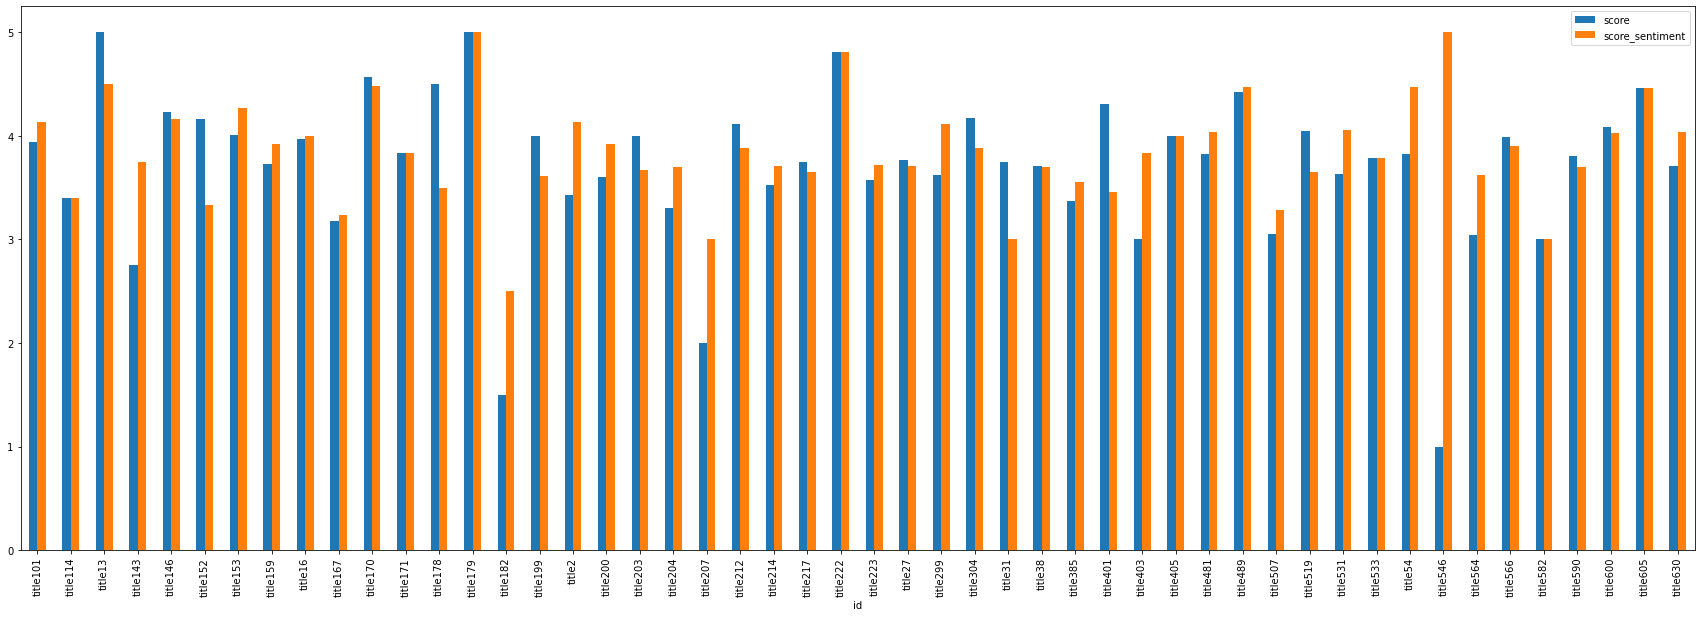

In [ ]:
scores_all[:50].plot.bar(figsize=(30, 10))

In [ ]:
review_count = df_final[~df_final['id'].isin(games_with_zero)].groupby('id')['text'].count().reset_index()

In [ ]:
review_count.columns = ['id', 'text_count']

In [ ]:
review_count.head()

,id,text_count
0,title101,171
1,title114,5
2,title13,4
3,title143,4
4,title146,43


In [ ]:
scores_all = scores_all.merge(review_count, on='id').sort_values(by=['score_sentiment'], ascending=True)

In [ ]:
scores_all[:10]

,id,score,score_sentiment,text_count
14,title182,1.500,2.500,2
58,title697,4.667,2.833,6
20,title207,2.000,3.000,2
88,title83,1.000,3.000,2
29,title31,3.750,3.000,4
45,title582,3.000,3.000,2
9,title167,3.176,3.235,17
37,title507,3.056,3.284,162
5,title152,4.167,3.333,6
63,title75,4.273,3.333,33


## Discover the reviews count

In [ ]:
df_final.head()

,id,score,text,is_about_localization,language,language_full,en_trans,sentiment_vader,compound,score_sentiment,is_pos
0,title777,1,没有华语版本,True,zh,Chinese,No Chinese version,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",-0.2960,2,0
1,title777,5,没有中文字.很难玩-很好玩的游戏.只可惜语言不明,True,zh,Chinese,No Chinese characters. Hard to play-very fun g...,"{'neg': 0.289, 'neu': 0.547, 'pos': 0.164, 'co...",-0.1280,3,0
2,title777,5,Excellent en français et connexion Facebook sa...,True,fr,French,Excellent in French and Facebook connection wi...,"{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp...",0.5719,4,1
3,title777,5,재밌어요. 영어까막눈이라 한국어 패치 됐음 좋겠어요.,True,ko,Korean,"fun. It’s English black eyes, so I hope that t...","{'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compou...",0.7930,5,1
4,title777,5,연료.. 너무안주고ㅜ 한국어로좀 번역좀해주시지. .정보도없고ㅜㅜ 잼있긴 잼있음 ㅋㅋ,True,ko,Korean,Don't give me fuel.. Please translate it into ...,"{'neg': 0.056, 'neu': 0.668, 'pos': 0.276, 'co...",0.7391,5,1


In [ ]:
neg_review_count = df_final[df_final['is_pos']==0].groupby('id')['text'].count().reset_index().sort_values(by='text', ascending=False)
neg_review_count.head(10)

,id,text
24,title249,2134
70,title658,723
109,title885,548
75,title700,527
40,title407,434
105,title832,267
73,title675,264
81,title765,187
66,title631,169
69,title655,137


There are 10 games with most count of negative location reviews. Let's see what languages asked more.

Usually the primary language for a new game is an English, so I assume that people that wrote reviews in English are not asked about the translation. Of course it's not true, but let's do it to have a fast overview.

In [ ]:
df_to_dashboard_negative_top = df_final[(df_final['id'].isin(neg_review_count['id'].tolist()[:10])) & (df_final['is_pos']==0) & (df_final['language_full']!='English')][['id', 'language_full', 'score_sentiment', 'is_pos']]

In [ ]:
# neg_review_by_language = pd.DataFrame(columns=['language_full','text'])
for i in neg_review_count['id'].tolist()[:10]:
  df = df_final[(df_final['id']==i) & (df_final['is_pos']==0) & (df_final['language_full']!='English')].groupby('language_full')['text'].count().reset_index().sort_values(by='text', ascending=False)
  print("game:", i)
  print(df.head(10))
  print('')

  top_lang = df['language_full'][:4]
  df_to_dashboard_negative_top['language_full'] = np.where(~(df_to_dashboard_negative_top['language_full'].isin(top_lang)) & (df_to_dashboard_negative_top['id'] == i), 'Other', df_to_dashboard_negative_top['language_full'])

game: title249
   language_full  text
0        Chinese   299
5         German   102
12       Russian    74
6     Indonesian    36
16       Turkish    31
4         French    22
9         Korean    17
13       Spanish    16
10        Polish    15
11    Portuguese    12

game: title658
   language_full  text
11       Russian   232
3         French   186
14       Turkish   112
6        Italian    63
4         German    42
8         Korean    23
12       Spanish    11
5     Indonesian     9
9         Polish     8
1        Chinese     7

game: title885
   language_full  text
15       Turkish   163
14          Thai    81
5     Indonesian    64
8         Korean    50
1        Chinese    40
0         Arabic    28
10        Polish    27
11    Portuguese    15
7       Japanese    14
12       Russian    14

game: title700
   language_full  text
20       Turkish   134
12        Korean    61
11      Japanese    58
0         Arabic    36
9     Indonesian    29
16       Russian    25
19          Thai 

## Top languages among localization reviews
10 games with most count of reviews about localization

In [ ]:
popular_games_without_loc = scores_all.sort_values(by=['text_count'], ascending=False)['id'][:10].tolist()

In [ ]:
popular_games_without_loc

['title885',
 'title658',
 'title700',
 'title832',
 'title655',
 'title675',
 'title765',
 'title631',
 'title600',
 'title782']

In [ ]:
df_final[df_final['id'].isin(popular_games_without_loc)].groupby('language_full')['language_full'].count().sort_values(ascending=False)

language_full
Turkish       3175
Portuguese    1649
English       1547
Thai          1480
Russian       1454
Indonesian    1204
French         898
Korean         809
Italian        792
Arabic         673
German         626
Chinese        624
Polish         550
Japanese       377
Spanish        281
Dutch          115
Vietnamese      69
Czech           53
Greek           41
Norwegian       18
Hebrew          12
Swedish         11
Danish          10
Finnish          9
Hindi            2
Name: language_full, dtype: int64

In [ ]:
df_final.groupby('language_full')['language_full'].count().sort_values(ascending=False)

language_full
English       8000
Turkish       4510
Portuguese    3755
Chinese       3260
Russian       2537
Thai          1729
Korean        1596
Indonesian    1576
French        1491
German        1390
Italian       1367
Spanish        875
Japanese       798
Arabic         794
Polish         767
Dutch          314
Czech          118
Vietnamese     109
Norwegian       49
Greek           46
Swedish         34
Finnish         33
Danish          32
Hebrew          21
Hindi            3
Name: language_full, dtype: int64

# Conclusion

**We do not really know the reasons for negative reviews.**
VADER rely on words' emotional, so the review is negative because the reviewer used negative emotion words. 

**We do know the sentiment of all reviews.**
So we can assume that a negative review tells about a problem with a language the review was written on.


The languages, the most localization reviews are written, are *English*, *Turkish*, *Portuguese*, *Thai*, *Russian*, *Chinese*, *Korean*, *French*, *German*, *Italian* and *Indonesian*. 



 